# Keep Employee - Predict employer turnover

## Goal
Employee turnover refers to the number or percentage of the employees who leave the company and replaced by new employees.  Employee turnover has been rampant in the company. The CFO estimates that the cost of replacing an employee is often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

Our goal is to predict employee retention and understand its main drivers.

## Data
We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as average salary during his/her tenure, department, and years of experience.

1. **employee_id** : id of the employee. Unique by employee per company
2. **company_id** : company id.
3. **dept** : employee department
4. **seniority** : number of yrs of work experience when hired
5. **salary**: average yearly salary of the employee during her tenure within the company
6. **join_date**: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
7. **quit_date**: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv("employee_retention.txt")

In [5]:
df.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [6]:
df.dtypes

Unnamed: 0       int64
employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

## 1. Data Wragling and Cleaning

In [5]:
df["employee_id"] = df["employee_id"].astype(int)

In [6]:
df = df.drop(["Unnamed: 0"], axis=1)

In [9]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804,8,design,21,191000.0,05.17.2011,2012-03-16
2,407990,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


### Create the label column whether the employee leave or not

In [7]:
df["leave"] = [0 if x == True else 1 for x in df["quit_date"].isnull()]

In [8]:
df.head(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,leave
0,1001444,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25,1
1,388804,8,design,21,191000.0,05.17.2011,2012-03-16,1
2,407990,3,design,9,90000.0,2012-03-26,2015-04-10,1
3,120657,2,engineer,20,298000.0,2013-04-08,2015-01-30,1
4,1006393,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18,1
5,287530,5,marketing,20,180000.0,2014-06-30,NaN,0
6,561043,3,customer_service,18,119000.0,2012-07-02,2014-03-28,1
7,702479,7,data_science,7,140000.0,12.27.2011,2013-08-30,1
8,545690,10,data_science,16,238000.0,12.23.2013,NaN,0
9,622587,5,sales,28,166000.0,2015-07-01,NaN,0


In [12]:
df.describe()

,employee_id,company_id,seniority,salary,leave
count,3.470200e+04,34702.000000,34702.000000,34463.000000,34702.000000
mean,6.466667e+05,4.023370,10.056625,100280.585004,0.677483
std,3.337653e+05,2.911201,9.355505,87322.502536,0.467447
min,3.600000e+01,1.000000,0.000000,5000.000000,0.000000
25%,3.529228e+05,1.000000,0.000000,9302.000000,0.000000
50%,7.063230e+05,3.000000,8.000000,88000.000000,1.000000
75%,1.001324e+06,6.000000,18.000000,158000.000000,1.000000
max,1.009999e+06,12.000000,99.000000,408000.000000,1.000000


### Remove error data
From the summary of the data, 99 years seniority does not make sense.  Seach for these data. 

In [9]:
df[df["seniority"] > 30]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,leave
23683,97289,10,engineer,98,266000.0,2011-12-13,2015-01-09,1
26543,604052,1,marketing,99,185000.0,2011-07-26,2013-12-06,1


In [10]:
# Delete the wrong data because there is only two data points
df = df[df["seniority"] <= 30]

###  Check for missing data

In [15]:
np.sum(df.isnull())

employee_id        0
company_id         0
dept               0
seniority          0
salary           239
join_date          0
quit_date      11192
leave              0
dtype: int64

`salary` and `quit_date` contain missing data.  Missing data `quit_data` are due to the employee not leaving. So deal with `quit_data` first.

### Deal with date
Transfer date column to datetime in pandas

In [11]:
df["join_date"] = [pd.to_datetime(x, format="%m.%d.%Y") if re.match(r"(\d+)\.", x) else x for x in df["join_date"]]

In [12]:
df["quit_date"] = df["quit_date"].fillna(pd.to_datetime("2015-12-13", format="%Y-%m-%d"))

In [13]:
df["quit_date"] = [pd.to_datetime(x, format="%Y-%m-%d") for x in df["quit_date"]]

### Deal with missing data in salary

In [14]:
np.sum(df.isnull())

employee_id      0
company_id       0
dept             0
seniority        0
salary         239
join_date        0
quit_date        0
leave            0
dtype: int64

In [15]:
print("The ratio of missing value in column salary is {:.4}".format(239 / df.shape[0]))

The ratio of missing value in column salary is 0.006888


In [16]:
df_new = df.dropna(subset=["salary"])

In [25]:
print(df.describe())
print(df_new.describe())

        employee_id    company_id     seniority         salary         leave
count  3.470000e+04  34700.000000  34700.000000   34461.000000  34700.000000
mean   6.466837e+05      4.023285     10.051527  100273.317692      0.677464
std    3.337618e+05      2.911062      9.331646   87319.280339      0.467454
min    3.600000e+01      1.000000      0.000000    5000.000000      0.000000
25%    3.529462e+05      1.000000      0.000000    9302.000000      0.000000
50%    7.063750e+05      3.000000      8.000000   88000.000000      1.000000
75%    1.001324e+06      6.000000     18.000000  158000.000000      1.000000
max    1.009999e+06     12.000000     29.000000  408000.000000      1.000000
        employee_id    company_id     seniority         salary         leave
count  3.446100e+04  34461.000000  34461.000000   34461.000000  34461.000000
mean   6.477072e+05      4.026755     10.026320  100273.317692      0.678361
std    3.338259e+05      2.912156      9.335557   87319.280339      0.467112

There seems to be not much difference after removing the missing data.  So we directly delete the missing data.

In [17]:
df = df_new

## 2. Feature Engineering

### Compute the time during the person stay in the company in days

In [18]:
df["duration"] = pd.to_datetime(df["quit_date"]) - pd.to_datetime(df["join_date"])

In [19]:
df["duration"] = df["duration"].dt.days

Text(0, 0.5, 'Count')

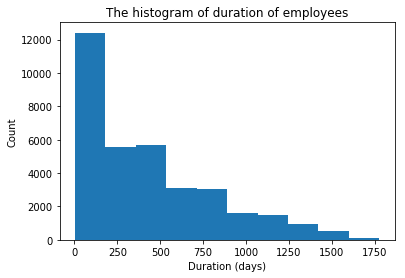

In [20]:
plt.hist(df["duration"])
plt.title("The histogram of duration of employees")
plt.xlabel("Duration (days)")
plt.ylabel("Count")

There are a large portion of employee with duration less than 100 days.  Look into it. 

In [21]:
df[df["duration"] <= 100].head(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,leave,duration
0,1001444,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25,1,90
4,1006393,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18,1,90
17,1007464,7,temp_contractor,0,7748.0,2009-11-14,2010-02-12,1,90
18,1002775,3,temp_contractor,0,7424.0,2008-01-14,2008-04-13,1,90
20,1000103,5,temp_contractor,0,9684.0,2008-05-18,2008-08-16,1,90
21,34604,2,design,29,224000.0,2015-09-08,2015-12-13,0,96
22,1008116,4,temp_contractor,0,9865.0,2010-10-03,2011-01-01,1,90
24,1003092,2,temp_contractor,0,5459.0,2009-09-23,2009-12-22,1,90
26,1007778,7,temp_contractor,0,6749.0,2007-02-14,2007-05-15,1,90
33,1006601,8,temp_contractor,0,9051.0,2008-03-11,2008-06-09,1,90


Most of them are `temp_contractor`. Let's check temp_contractor data.

In [22]:
temp_contractor = df[df["dept"] == 'temp_contractor']
temp_contractor.describe()

,employee_id,company_id,seniority,salary,leave,duration
count,1.000000e+04,10000.000000,10000.0,10000.000000,10000.0,10000.0
mean,1.005000e+06,5.496600,0.0,7510.980100,1.0,90.0
std,2.886896e+03,2.890333,0.0,1439.510641,0.0,0.0
min,1.000000e+06,1.000000,0.0,5000.000000,1.0,90.0
25%,1.002500e+06,3.000000,0.0,6278.000000,1.0,90.0
50%,1.005000e+06,5.000000,0.0,7519.000000,1.0,90.0
75%,1.007499e+06,8.000000,0.0,8774.000000,1.0,90.0
max,1.009999e+06,10.000000,0.0,9999.000000,1.0,90.0


### Remove temp_contractor from data set

The duration of temp contractor is always 90 days.  We are more concerning about whether full-time employee will leave or not. Including temp contractor data migth skew our dataset. Let's look at their salary to see whether they will cause some bias in our data.

Text(0.5, 1.0, 'Salary of temp_contractor')

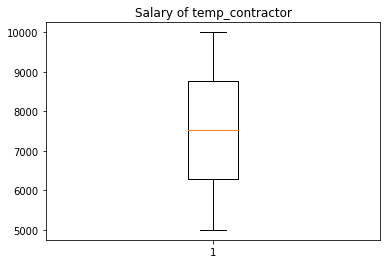

In [23]:
plt.boxplot(temp_contractor["salary"])
plt.title("Salary of temp_contractor")


Text(0, 0.5, 'Count')

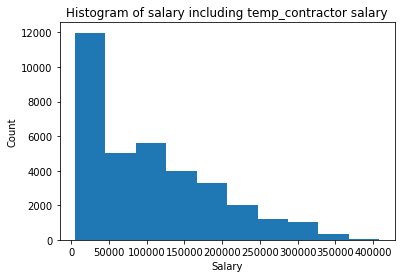

In [33]:
plt.hist(df["salary"])
plt.title("Histogram of salary including temp_contractor salary")
plt.xlabel("Salary")
plt.ylabel("Count")

Let's remove temp contractor from our data.

In [24]:
df = df[df["dept"] != "temp_contractor"]

Text(0, 0.5, 'Count')

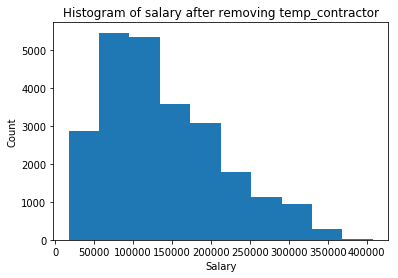

In [25]:
plt.hist(df["salary"])
plt.title("Histogram of salary after removing temp_contractor")
plt.xlabel("Salary")
plt.ylabel("Count")

The skewness of the data is better after we removed temp_contractor.  

In [36]:
df["leave"].value_counts()

1    13377
0    11084
Name: leave, dtype: int64

After removing temp contractor, the number of employee leave and not leave is more balanced.

## 3. Exploratory Data Analysis

Draw the distribution of `salary`, `duration`, `seniority` to see whether there is difference between people who stayed and people who left.

In [26]:
stay_df = df[df["leave"] == 0]
leave_df = df[df["leave"] == 1]

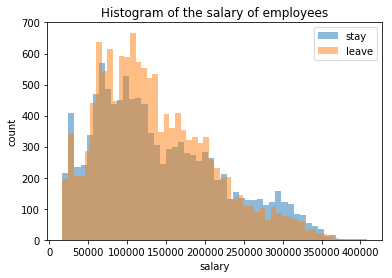

In [57]:
plt.hist(stay_df["salary"], bins=50, alpha=0.5, label='stay')
plt.hist(leave_df["salary"], bins=50, alpha=0.5, label='leave')
plt.xlabel("salary")
plt.ylabel("count")
plt.title("Histogram of the salary of employees")
plt.legend(loc="upper right")

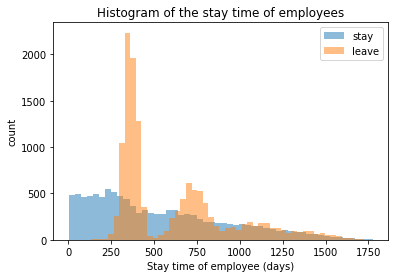

In [63]:
plt.hist(stay_df["duration"], bins=50, alpha=0.5, label='stay')
plt.hist(leave_df["duration"], bins=50, alpha=0.5, label='leave')
plt.xlabel("Stay time of employee (days)")
plt.ylabel("count")
plt.title("Histogram of the stay time of employees")
plt.legend(loc="upper right")

The distributions of stay time of employees differ a lot between employees who stayed and employees who left.

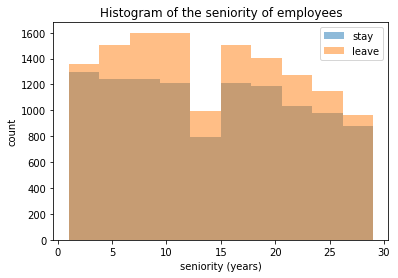

In [61]:
plt.hist(stay_df["seniority"], alpha=0.5, label='stay')
plt.hist(leave_df["seniority"], alpha=0.5, label='leave')
plt.xlabel("seniority (years)")
plt.ylabel("count")
plt.title("Histogram of the seniority of employees")
plt.legend(loc="upper right")

In [40]:
df.columns

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date', 'leave', 'duration'],
      dtype='object')

### T-test to compare the mean of the three factors between people staying and people leaving.
There are two groups, one is people staying in the company, the other is people that left the company. The null hypothesis is there is no difference of stay time / salary / seniority between these two groups.

In [35]:
from scipy import stats
t_duration, p_duration = stats.ttest_ind(stay_df["duration"], leave_df["duration"])
t_salary, p_salary = stats.ttest_ind(stay_df["salary"], leave_df["salary"])
t_seniority, p_seniority = stats.ttest_ind(stay_df["seniority"], leave_df["seniority"])

print("t-statistics of stay time is {:.2f}. p-value is {}".format(t_duration, p_duration))
print("t-statistics of salary is {:.2f}. p-value is {}".format(t_salary, p_salary))
print("t-statistics of seniority is {:.2f}. p-value is {}".format(t_seniority, p_seniority))

t-statistics of stay time is -18.65. p-value is 4.424981149883956e-77
t-statistics of salary is 5.61. p-value is 2.0201063867658888e-08
t-statistics of seniority is -0.06. p-value is 0.9517660916210183


If we set the threshold to be 0.05, we can reject the null hyposis for `stay_time` and `salary` with confidence but not `seniority`.  `stay_time` have more difference between two groups. 

### Survey whether different company contains different ratio of leaving

Text(0.5, 1.0, 'The leaving ratio of different companies')

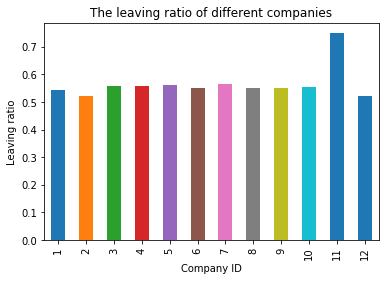

In [41]:
groupby_company = df.groupby(by=["company_id", "leave"])["employee_id"].count().unstack()
groupby_company["leave_ratio"] = groupby_company[1] / (groupby_company[0] + groupby_company[1])
groupby_company["leave_ratio"].plot.bar()
plt.xlabel("Company ID")
plt.ylabel("Leaving ratio")
plt.title("The leaving ratio of different companies")


The leaving ratio of company 11 is much higher.  Let's take a look. 


In [42]:
groupby_company

leave,0,1,leave_ratio
company_id,,,
1,3826,4581,0.544903
2,1999,2181,0.521770
3,1205,1519,0.557636
4,900,1142,0.559256
5,764,976,0.560920
6,573,703,0.550940
7,526,683,0.564930
8,464,568,0.550388
9,430,524,0.549266


Company 11 and 12 contains much less samples. They don't contain enough data to derive statistic significant conclusion. Let's remove these data for now. 

In [43]:
df = df[(df["company_id"] != 11) & (df["company_id"] != 12)]

### Check the leaving ratio of different department

In [44]:
groupby_dept = df.groupby(by=['dept', "leave"])["employee_id"].count().unstack()

Text(0.5, 1.0, 'The leaving ratio of different department')

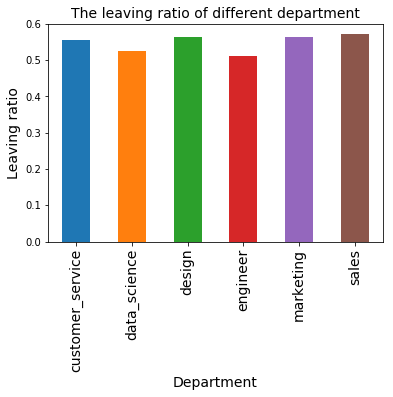

In [45]:
groupby_dept["leave_ratio"] = groupby_dept[1] / (groupby_dept[0] + groupby_dept[1])
groupby_dept["leave_ratio"].plot.bar()
plt.xlabel("Department", fontsize =14)
plt.ylabel("Leaving ratio", fontsize =14)
plt.xticks(fontsize=14)
plt.title("The leaving ratio of different department", fontsize =14)

Let's see the leaving ratio with same company and department.


In [46]:
df_leave = df[df["leave"] == 1]

In [47]:
df_leave_groupby_company_dept = df_leave.groupby(by=['company_id', 'dept'])["employee_id"].count().unstack()
df_leave_groupby_company_dept.head()

dept,customer_service,data_science,design,engineer,marketing,sales
company_id,,,,,,
1,1791,562,265,738,613,612
2,828,265,126,380,291,291
3,538,193,81,291,213,203
4,412,159,60,208,153,150
5,353,113,70,178,114,148


In [48]:
groupby_company_dept = df.groupby(by=['company_id', 'dept'])["employee_id"].count().unstack()

In [109]:
groupby_company_dept.head()

dept,customer_service,data_science,design,engineer,marketing,sales
company_id,,,,,,
1,3129,1070,491,1552,1074,1091
2,1530,562,223,822,535,508
3,1000,345,141,512,367,359
4,769,277,106,375,263,252
5,631,213,107,311,224,254


In [110]:
leave_ratio_grouped = df_leave_groupby_company_dept / groupby_company_dept

In [111]:
leave_ratio_grouped.head()

dept,customer_service,data_science,design,engineer,marketing,sales
company_id,,,,,,
1,0.572387,0.525234,0.539715,0.475515,0.570764,0.560953
2,0.541176,0.471530,0.565022,0.462287,0.543925,0.572835
3,0.538000,0.559420,0.574468,0.568359,0.580381,0.565460
4,0.535761,0.574007,0.566038,0.554667,0.581749,0.595238
5,0.559429,0.530516,0.654206,0.572347,0.508929,0.582677


### Heatmap of leaving ratio across different company and department
The lighter the color is, the higher the leaving ratio is. Each cell of the heatmap corresonding to one company and one department. If the colors are similar across cells, there is no significant difference across different company and department. 

Text(0.5, 1.0, 'Heatmap of leave ratio of different company and department')

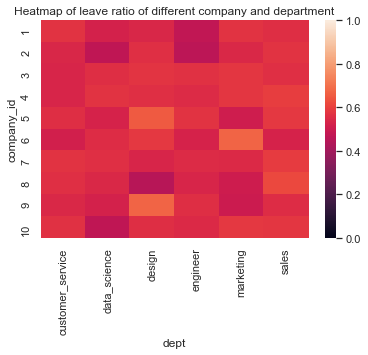

In [113]:
import seaborn as sns; 
sns.set()
ax = sns.heatmap(leave_ratio_grouped, vmin=0, vmax=1)
ax.set_title("Heatmap of leave ratio of different company and department")


It seems that there is no significant difference between the leaving ratio of different company and different department. So we will build the prediction model for all data.

## 4. Building the prediction model
Building the prediction model based on the three features: `seniority`, `salary`, `duration`
Labels: leave

In [72]:
X = df[['company_id', 'dept', 'seniority', 'salary', 'duration']]
y = df['leave']

In [73]:
X.head()

,company_id,dept,seniority,salary,duration
1,8,design,21,191000.0,304
2,3,design,9,90000.0,1110
3,2,engineer,20,298000.0,662
5,5,marketing,20,180000.0,531
6,3,customer_service,18,119000.0,634


### One hot coding category columsn and split the training data and test data

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [75]:
X.loc[:, 'company_id'] = X.loc[:, 'company_id'].astype('category')

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [76]:
X = pd.get_dummies(X, columns=['company_id', 'dept'])

In [168]:
X.head()

,seniority,salary,duration,company_id_1,company_id_2,company_id_3,company_id_4,company_id_5,company_id_6,company_id_7,company_id_8,company_id_9,company_id_10,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
1,21,191000.0,304,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,9,90000.0,1110,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,20,298000.0,662,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,20,180000.0,531,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
6,18,119000.0,634,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Scale the features

Scaling the feature could make Logitstic Regression converge sooner.  It's required when using model like SVM.

In [78]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### LogisticRegression
Use Logistic Regression as the base line.

In [183]:
param = {"C": [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(solver="lbfgs", max_iter=2000), param, cv=5)

In [184]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [185]:
grid_search.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [186]:
print("Accuracy of Logistic Regression on Training data {:.3f}".format(grid_search.score(X_train, y_train)))
print("Accuracy of Logistic Regression on Training data {:.3f}".format(grid_search.score(X_test, y_test)))


Accuracy of Logistic Regression on Training data 0.623
Accuracy of Logistic Regression on Training data 0.614


### Random forest

In [187]:
param = {"n_estimators": [100, 150], 
        "max_depth": [2, 4, 6]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param, cv=5)

In [188]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 150], 'max_depth': [2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [190]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [191]:
print("Accuracy of Random Forest on Training data {:.3f}".format(grid_search.score(X_train, y_train)))
print("Accuracy of Random Forest on Training data {:.3f}".format(grid_search.score(X_test, y_test)))


Accuracy of Random Forest on Training data 0.710
Accuracy of Random Forest on Training data 0.697


### Gradient Boosting Machine

In [81]:
from sklearn.ensemble import GradientBoostingClassifier

In [82]:
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [83]:
gbm.score(X_train, y_train)

0.791111596418432

In [84]:
gbm.score(X_test, y_test)

0.7849656075990828

Gradient Boosting Models have best performance. Check the feature importance.

In [85]:
feature_importance = pd.DataFrame()

In [86]:
feature_importance["feature_name"] = X.columns
feature_importance["feature importance"] = gbm.feature_importances_ 

In [87]:
feature_importance = feature_importance.sort_values(by=["feature importance"], ascending=False)


In [88]:
feature_importance.head(10)

,feature_name,feature importance
2,duration,0.976475
1,salary,0.019887
0,seniority,0.001908
11,company_id_9,0.000293
6,company_id_4,0.000283
12,company_id_10,0.000215
5,company_id_3,0.000208
4,company_id_2,0.000181
7,company_id_5,0.000156
9,company_id_7,0.000145


Text(0.5, 1.0, 'Top 10 important features for employee leave predictor')

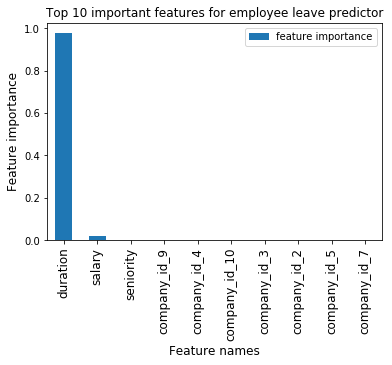

In [89]:
top_10_features = feature_importance[0:10].set_index("feature_name")
top_10_features.plot.bar()
plt.ylabel("Feature importance", fontsize=12)
plt.xlabel("Feature names", fontsize=12)
plt.xticks(fontsize=12)
plt.title("Top 10 important features for employee leave predictor", fontsize=12)

## 5. Result Analysis

The most important factor affecting the employee turnover is the time of their stay in the company. It is consistent with our EDA, where the distribution of employee stay time differ a lot between leave and not leave.

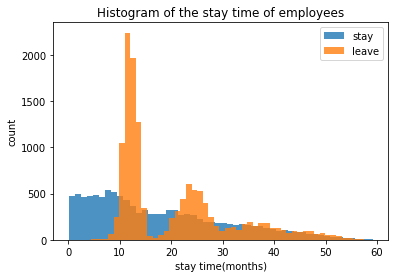

In [27]:
stay_df = df[df["leave"] == 0]
leave_df = df[df["leave"] == 1]

plt.hist(stay_df["duration"]/30, bins=50, alpha=0.8, label='stay')
plt.hist(leave_df["duration"] / 30, bins=50, alpha=0.8, label='leave')
plt.xlabel("stay time(months)")
plt.ylabel("count")
plt.title("Histogram of the stay time of employees")
plt.legend(loc="upper right")

It is illustrated in the figure that there are two peaks of turn over around 12 months and 24 months. Let's compare the turnover ratio over time.

### Compute the relationship between the leaving ratio and the time in the company 

In [93]:
sorted_df = df.loc[:, ["duration", "leave"]].sort_values(by=["duration"])

In [94]:
max_months = 60
duration_month = [0] * max_months

leave_ratio = [0] * max_months
i = 0
index = 0
for month in np.arange(max_months):
    duration_month[index] = month
    num_leave = 0
    num_total = 0
    while i < len(sorted_df):
        num_total += 1
        stay = int(sorted_df.iloc[i, 0] / 30)
        if stay < month: 
            if sorted_df.iloc[i, 1] == 1:
                num_leave += 1;
        else:
            try:
                leave_ratio[stay] = num_leave/num_total
            except ZeroDivisionError:
                print(str(month) + " " + str(num_leave) + " " + str(num_total))
                pass
            i = 0
            break
        i += 1
    index += 1
    

Text(0.5, 1.0, 'Trend of Turnover ratio vs Employee Stay Time in the company')

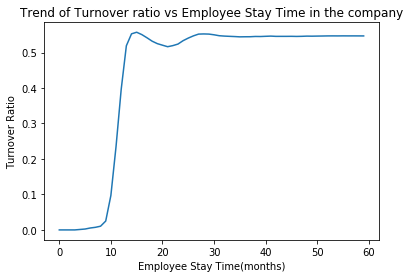

In [95]:
plt.plot(duration_month, leave_ratio)
plt.xlabel("Employee Stay Time(months)")
plt.ylabel("Turnover Ratio")
plt.title("Trend of Turnover ratio vs Employee Stay Time in the company")

The figure shows the leaving ratio has a great increase around 13 months. It means the employee tend to leave when they have stayed in the company for around 13 monthis.  The company need do something to keep the employee at the time. 

## Conclusion
The time the employee stayed in the company is the most important factor of turnover. The analysis shows when the employee has stayed in the company for around 13 months, the turnover rate begin to increase a lot. The company need to action to keep these employee. For example, we could do survey when employees reach their one-year and two years anniversary to know what are their concerns and expectation of the company. 

To know more about the reason of turn over, we'd better collect more data like whether and when employees get a promotion in the company, when and how much the salary increase or even their rating of performance over time. These data would give us more insight on the reason of turnover and take action to decrease turnover. 